input = torch.randn(1, 1, 32, 32)
# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [1]:
import os
import json
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'resources/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'resources/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'resources/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

Early stop at 1000th file..



### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [3]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = None
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [4]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [5]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [6]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 2.2801



loss is: 2.1604



loss is: 2.1240



loss is: 2.1004



loss is: 2.0825



loss is: 2.0673



loss is: 2.0541



loss is: 2.0422



loss is: 2.0313



loss is: 2.0210
Time is: 4 min 24 sec


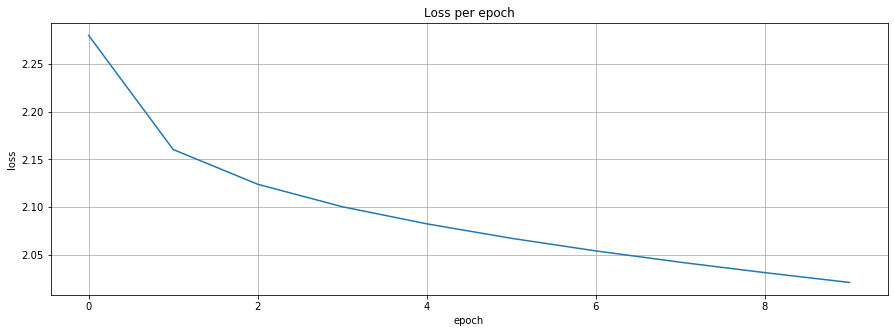

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [8]:
net.cpu()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.428


In [9]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.96 : 21600/22490
SPN: 0.01 : 9/705
AA0: 0.00 : 0/33
AA1: 0.30 : 554/1834
AA2: 0.00 : 0/81
AE0: 0.00 : 0/46
AE1: 0.46 : 1722/3729
AE2: 0.00 : 0/91
AH0: 0.31 : 1698/5440
AH1: 0.26 : 505/1912
AH2: 0.03 : 2/59
AO0: 0.00 : 0/21
AO1: 0.44 : 859/1949
AO2: 0.00 : 0/72
AW0: 0.00 : 0/4
AW1: 0.05 : 53/1031
AW2: 0.00 : 0/45
AY0: 0.00 : 0/28
AY1: 0.28 : 821/2886
AY2: 0.00 : 0/167
B  : 0.11 : 169/1509
CH : 0.05 : 48/906
D  : 0.18 : 706/3903
DH : 0.03 : 66/1976
EH0: 0.00 : 0/63
EH1: 0.27 : 760/2867
EH2: 0.00 : 0/90
ER0: 0.23 : 618/2700
ER1: 0.10 : 103/983
ER2: 0.00 : 0/17
EY0: 0.00 : 0/34
EY1: 0.40 : 1000/2483
EY2: 0.00 : 0/133
F  : 0.48 : 1148/2412
G  : 0.02 : 15/812
HH : 0.25 : 543/2142
IH0: 0.08 : 202/2689
IH1: 0.12 : 281/2364
IH2: 0.00 : 0/86
IY0: 0.21 : 496/2310
IY1: 0.62 : 1451/2344
IY2: 0.00 : 0/45
JH : 0.02 : 12/658
K  : 0.24 : 742/3106
L  : 0.51 : 2148/4207
M  : 0.35 : 1087/3127
N  : 0.42 : 2628/6251
NG : 0.11 : 153/1372
OW0: 0.00 : 0/186
OW1: 0.27 : 520/1893
OW2: 0.00 : 0/84
OY1: 0.

### Распознавание по словарю с помощью нейронки

In [10]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [11]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [12]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        ftr_frame = features[frame]
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [13]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [14]:
lexicon_file = 'resources/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("resources/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: no_4394fc7c_nohash_0        ==> YES
result: no_4abb2400_nohash_0        ==> YES
result: yes_39a6b995_nohash_0       ==> YES
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.45 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [15]:
lexicon_file = 'resources/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("resources/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: zero_f852895b_nohash_0      ==> SEVEN
result: four_ffbb695d_nohash_0      ==> FOUR
result: nine_fbe51750_nohash_0      ==> NINE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_fc2411fe_nohash_0       ==> NINE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: three_feb1d305_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> FOUR
result: seven_fd32732a_nohash_0     ==> SEVEN
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: nine_ccea893d_nohash_0      ==> NINE
result: eight_da584bc0_nohash_4     ==> SIX
result: five_f852895b_nohash_0      ==> FIVE
result: two_fce65496_nohash_0       ==> TWO
result: three_fce96bac_nohash_0     ==> THREE
result: six_ffbb695d_nohash_0       ==> SIX
result: six_ffd2ba2f_nohash_0       ==> SIX
result: two_fb2f3242_nohash_0       ==> TWO
result: one_ffa76c4a_nohash_0       ==> FOUR
------------------------------------------------------------
WER is: 20.00%
Total time is: 20.81 s

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

In [16]:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=0, strip=1):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        file_feats_len = min(len(file_feats), len(file_ali))
        file_feats = np.vstack((np.tile(file_feats[0], (side_context,1)), file_feats)) #Добавляем повторение первого элемента в начало side_context раз
        file_feats = np.vstack((file_feats, (np.tile(file_feats[-1], (side_context,1))))) #Добавляем повторение посоедннго элемента в конец side_context раз
        for frame in range(side_context, file_feats_len):
            slice_feat = file_feats[frame - side_context: frame + side_context + 1:strip]
            feats = slice_feat.reshape(file_feats[frame].shape[0] * slice_feat.shape[0], )
            data_list.append(np.append(feats, phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    
    return data_list, np.array(priors_list)/sum(priors_list)

In [17]:
def recognize(filename, features, graph, nnet, recognition_results, beam_threshold, side_context=0, strip=1):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    feat_len = len(features)
    features = np.vstack((np.tile(features[0], (side_context,1)), features))
    features = np.vstack((features, (np.tile(features[-1], (side_context,1)))))
    for frame in range(side_context, feat_len):
        slice_feat = features[frame - side_context: frame + side_context + 1:strip]
        ftr_frame = slice_feat.reshape(features[frame].shape[0] * slice_feat.shape[0], )
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10, side_context=0, strip=1):
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold, side_context, strip)

    WER = round((1 - sum(recognition_results)/len(recognition_results))*100, 2)
    return WER

In [18]:
LOAD_DATA = True

In [19]:
if LOAD_DATA == False:
    context_result = dict()
    for side_context, strip, name in zip(
                                        [0, 1, 2, 2, 3, 3],
                                        [1, 1, 1, 2, 1, 3],
                                        ['side_context-0-strip-1',
                                         'side_context-1-strip-1',
                                         'side_context-2-strip-1',
                                         'side_context-2-strip-2',
                                         'side_context-3-strip-1',
                                         'side_context-3-strip-3']
                                        ):
        context_result[name] = {}
        data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context, strip)
        data_list = np.random.permutation(data_list)
        device = torch.device('cpu')
        data_set = CommonDataSet(data_list, device)
        batch_size = 256

        # training network model:
        start = time.time() 
        net = MyNet(input_dim=(data_list[0].shape[0] - 1),
                    output_dim=len(phones_dict.keys())).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

        loss_list = []

        print(f'Training is started for {name}')
        for epoch in tqdm(range(10)):
            running_loss = 0
            counter = 0
            for batch_xs, batch_ys in data_set.next_batch(batch_size):
                optimizer.zero_grad()
                output = net(batch_xs)

                loss = criterion(output, batch_ys)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                counter += 1

            loss_list.append(running_loss / counter)
        context_result[name]['loss'] = loss_list

        net.cpu()
        with torch.no_grad():
            correct_cnt = 0
            for ftr, true_label in zip(data_set.valid[:, :-1], data_set.valid[:, -1]):
                ftr = torch.from_numpy(ftr).float()
                output = net.forward(ftr)
                correct_cnt += (output.argmax().item() == true_label)
        frame_accuracy = round(correct_cnt / data_set.valid.shape[0], 3)
        context_result[name]['accuracy'] = frame_accuracy

        class_correct = [0 for x in range(len(phones_dict.keys()))]
        class_total = [0 for x in range(len(phones_dict.keys()))]
        net.cpu()
        with torch.no_grad():
            for ftr, true_label in zip(data_set.valid[:, :-1], data_set.valid[:, -1]):
                ftr = torch.from_numpy(ftr).float()
                output = net.forward(ftr)
                predict_label = output.argmax().item()

                class_correct[predict_label] += (predict_label == int(true_label))
                class_total[int(true_label)] += 1

        context_result[name]['class_correct'] = class_correct
        context_result[name]['class_total'] = class_total

        lexicon_file = 'resources/lexicon_yes_no.txt'
        lexicon_dict = load_lexicon_dict(lexicon_file)
        graph = load_graph(lexicon_dict, phones_dict, priors_list)
        records_data_dict = load_data_dict("resources/yes_no/records")
        WER_yes_no = run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100, side_context=side_context, strip=strip)     

        lexicon_file = 'resources/lexicon_digits.txt'
        lexicon_dict = load_lexicon_dict(lexicon_file)
        graph = load_graph(lexicon_dict, phones_dict, priors_list)
        records_data_dict = load_data_dict("resources/digits/records")
        WER_digits = run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50, side_context=side_context, strip=strip)

        context_result[name]['WER_yes_no'] = WER_yes_no
        context_result[name]['WER_digits'] = WER_digits
        
    with open('resources/result-lab-02-04/result.json', 'w') as fp:
        json.dump(context_result, fp)
        
else:
    with open('resources/result-lab-02-04/result.txt', 'r') as fp:
        context_result = json.load(fp)

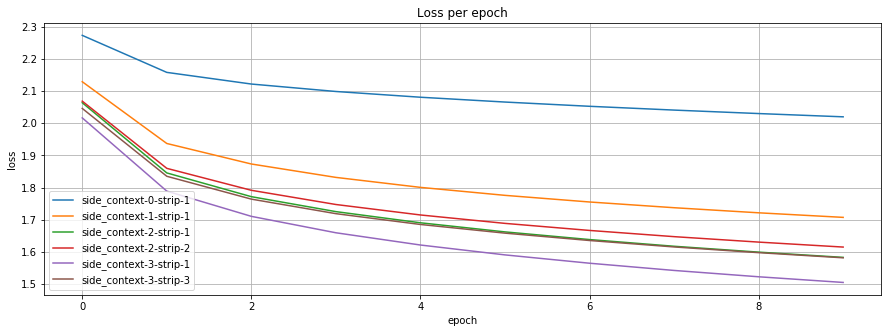

In [20]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
for name in context_result.keys():
    plt.plot(context_result[name]['loss'], label=name)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

In [21]:
print('Model Accuracy')
for name in context_result.keys():
    print(f"{name} --- {context_result[name]['accuracy']}")

Model Accuracy
side_context-0-strip-1 --- 0.426
side_context-1-strip-1 --- 0.497
side_context-2-strip-1 --- 0.528
side_context-2-strip-2 --- 0.522
side_context-3-strip-1 --- 0.551
side_context-3-strip-3 --- 0.531


In [22]:
print('Model WER_yes_no')
for name in context_result.keys():
    print(f"{name} --- {context_result[name]['WER_yes_no']}")

Model WER_yes_no
side_context-0-strip-1 --- 20.0
side_context-1-strip-1 --- 0.0
side_context-2-strip-1 --- 10.0
side_context-2-strip-2 --- 10.0
side_context-3-strip-1 --- 0.0
side_context-3-strip-3 --- 0.0


In [23]:
print('Model WER_digits')
for name in context_result.keys():
    print(f"{name} --- {context_result[name]['WER_digits']}")

Model WER_digits
side_context-0-strip-1 --- 20.0
side_context-1-strip-1 --- 10.0
side_context-2-strip-1 --- 0.0
side_context-2-strip-2 --- 5.0
side_context-3-strip-1 --- 5.0
side_context-3-strip-3 --- 0.0


### Выводы: Протестированы различные варинаты контекста side-context-{размер окна влево и вправо}-{через сколько элементов берутся фичи}. При всех их лосс уменьшился очень сильно при обучении. Сама точность модели увеличилась. А WER на датасетах уменьшились.

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

In [30]:
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, 3, 1)
data_list = np.random.permutation(data_list)

In [33]:
class NewNet(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(NewNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 1024
        n_nodes_hl2 = 512
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        n_nodes_hl5 = 128
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:

        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl4, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, n_nodes_hl5)
        self.fc6 = nn.Linear(n_nodes_hl5, output_dim)        
    
    def forward(self, x):  

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        
        return (x)

In [34]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = NewNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(20):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()        
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 2.1159



loss is: 1.8555



loss is: 1.7691



loss is: 1.7146



loss is: 1.6747



loss is: 1.6424



loss is: 1.6157



loss is: 1.5921



loss is: 1.5711



loss is: 1.5523



loss is: 1.5349



loss is: 1.5187



loss is: 1.5038



loss is: 1.4899



loss is: 1.4765



loss is: 1.4639



loss is: 1.4520



loss is: 1.4401



loss is: 1.4287



loss is: 1.4180
Time is: 17 min 40 sec


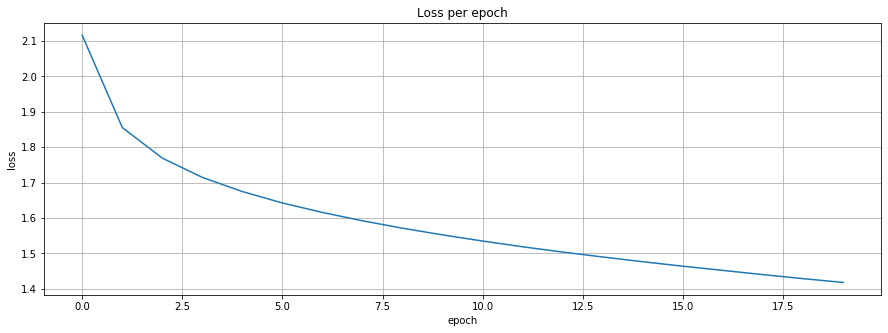

In [35]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [36]:
net.cpu()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.558


Выводы: Архитектура сетей: Первое что сразу захотелось - Добавить по сверточных слоев в начало, но качество наоборот стало меньше (возможно я что-то напутал и сделал неправильно). Просто попробовал поиграться с количеством слоев. Чуть поглубже сделал. Чуть добавил CosineAnnealingLR. Если брать эпох побольше, то точность будет всё скорее всего и ещё поменьше. Честно говоря не было сильно много времени ещё поиграться с этим заданием.(